In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [168]:
data = pd.read_csv('names_and_rubrics_learn.tsv', sep='\t', names=['name', 'categ'])
data.head()

,name,categ
0,Автобусная компания Транспорт52,Автобусные междугородные перевозки
1,Мастерок,Строительный магазин
2,Суши-бар,Суши-бар
3,Экспром,Металлоизделия
4,Универсам Бегемот,Супермаркет


In [3]:
unique = data.categ.unique()
str_to_unique = {s: i for i, s in enumerate(unique)}

In [169]:
name_str = data.name.values

In [170]:
name_str.shape

(8908449,)

In [171]:
def process_string(string):
    return " ".join(re.sub('[^a-zA-Zа-яА-ЯёЁ]+', ' ', string.lower()).split()).lower()

In [172]:
data.name = [process_string(s) for s in name_str]

In [173]:
data.head()

,name,categ
0,автобусная компания транспорт,Автобусные междугородные перевозки
1,мастерок,Строительный магазин
2,суши бар,Суши-бар
3,экспром,Металлоизделия
4,универсам бегемот,Супермаркет


In [38]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
l_enc = LabelEncoder()
l_enc.fit(data.categ.values)

In [ ]:
enc_categ = l_enc.transform(data.categ.values)

In [174]:
data['enc_categ'] = enc_categ
data.head()

,name,categ,enc_categ
0,автобусная компания транспорт,Автобусные междугородные перевозки,20
1,мастерок,Строительный магазин,989
2,суши бар,Суши-бар,1012
3,экспром,Металлоизделия,556
4,универсам бегемот,Супермаркет,1010


In [175]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((7126759, 3), (1781690, 3))

In [176]:
train = pd.concat([train, pd.DataFrame({'name': [process_string(s) for s in unique], 'categ': unique, 'enc_categ': l_enc.transform(unique)})])
train.shape

(7127981, 3)

In [177]:
train.tail()

,name,categ,enc_categ
1217,сцена,Сцена,1013
1218,танцплощадка,Танцплощадка,1023
1219,шлюз,Шлюз,1185
1220,фестиваль,Фестиваль,1130
1221,камера хранения,Камера хранения,347


In [178]:
train.shape

(7127981, 3)

In [ ]:
import tensorflow as tf
import keras.layers as L
import tensorflow_hub as hub
tf.reset_default_graph()
sess = tf.InteractiveSession()

universal_sentence_encoder_1 = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2", 
                                        trainable=False)

sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


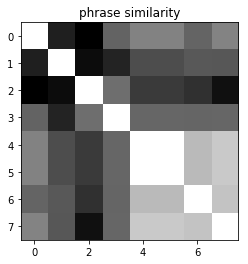

In [91]:
dummy_ph = tf.placeholder(tf.string, shape=[None])
dummy_vectors = universal_sentence_encoder_1(dummy_ph)

dummy_lines = [
    "Автобусная компания Транспорт52",                                                 # 0
    "Мастерок",  # 1
    "Автобусные междугородные перевозки",                # 2
    "Строительный магазин",                                                # 3
    "Суши-бар",               # 4
    "Суши-бар",
    "Универсам Бегемот",
    'Супермаркет'
]

dummy_vectors_np = sess.run(dummy_vectors, {
    dummy_ph: dummy_lines
})

plt.title('phrase similarity')
plt.imshow(dummy_vectors_np.dot(dummy_vectors_np.T), interpolation='none', cmap='gray')

In [245]:
class Net:
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder_1):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        self.universal_sentence_encoder = universal_sentence_encoder
        
        self.dense_1 = L.Dense(hid_size, activation='relu')
        self.dense_2 = L.Dense(hid_size, activation='relu')
        self.dense_3 = L.Dense(output_size, activation='relu')
        self.head = L.Dense(output_size)
#         self.batch_norm_1 = L.BatchNormalization()
#         self.batch_norm_2 = L.BatchNormalization()
        self.drop_1 = L.Dropout(0.2)
        self.drop_2 = L.Dropout(0.2)
        self.drop_3 = L.Dropout(0.2)
        

    def __call__(self, input_phrases, is_train=True):
        
        x = self.universal_sentence_encoder(input_phrases)
        x = self.drop_1(self.dense_1(x), training=is_train)
        x = self.drop_2(self.dense_2(x), training=is_train)
        x = self.drop_3(self.dense_3(x), training=is_train)
        return self.head(x)

In [246]:
net = Net(output_size=len(unique), hid_size=1024)

In [247]:
import utils

In [248]:
dummy_v_q = net(dummy_ph, is_train=True)
dummy_v_q_det = net(dummy_ph, is_train=False)
utils.initialize_uninitialized()
assert sess.run(dummy_v_q, {dummy_ph: dummy_lines}).shape == (8, len(unique))
assert np.allclose(
    sess.run(dummy_v_q_det, {dummy_ph: dummy_lines}),
    sess.run(dummy_v_q_det, {dummy_ph: dummy_lines})
)

print("Well done!")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Well done!


In [ ]:
import random

def iterate_minibatches(data, batch_size, total_batch_num, shuffle=True, cycle=False):
    
    indices = np.arange(len(data))
    cnt = 0
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['name'].values
            correct_answers = batch['enc_categ'].values
            yield {
                'names' : questions,
                'correct': correct_answers,
            }
            cnt += 1
            if cnt == total_batch_num:
                break
        if cnt == total_batch_num:
            break
        if not cycle:
            break

In [210]:
dummy_batch = next(iterate_minibatches(data.sample(3), 3, 10))
print(dummy_batch)
print(l_enc.inverse_transform(dummy_batch['correct']))

{'names': array(['белгород', 'азс газпром', 'сатон энерго'], dtype=object), 'correct': array([ 49,  10, 681])}
['Автотехпомощь, эвакуация автомобилей' 'АЗС'
 'Отопительное оборудование и системы']


In [249]:
placeholders = {
    'names': tf.placeholder(tf.string, [None]),
    'target': tf.placeholder(tf.int32, [None])
}
logits = net(placeholders['names'], is_train=True)
pred_logits = net(placeholders['names'], is_train=False)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=placeholders['target'], logits=logits))
# loss = tf.losses.softmax_cross_entropy(placeholders['target'], logits, weights=100.0)

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001, global_step=global_step, decay_steps=10000, decay_rate=0.1, 
                                          staircase=True)
optim = tf.train.AdamOptimizer(learning_rate=learning_rate)


step = optim.minimize(loss, global_step=global_step)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [250]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm_notebook

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=1500, total_batch_num=1000, cycle=True)
loss_history = []
dev_recall_history = []
utils.initialize_uninitialized()

In [182]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

Без дропаута просто и просто приведя строки к нижнему регистру.

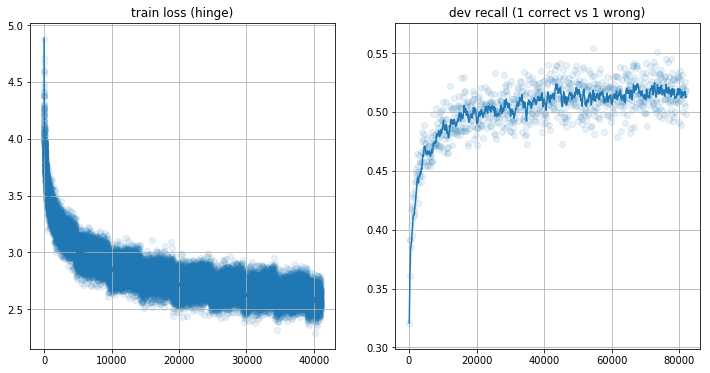

1000it [01:30, 11.05it/s]


In [99]:

for batch in tqdm(iterate_minibatches(train, batch_size=1500, total_batch_num=1000, cycle=True)):
    feed = {placeholders["names"] : batch["names"], placeholders['target']: batch['correct']}
    loss_t, _ = sess.run([loss, step], feed)
    loss_history.append(loss_t)

    if len(loss_history) % 50 == 0:

        dev_batch = next(dev_batches)
        dev_batch_pred = sess.run(pred_logits, {placeholders['names']: dev_batch['names']})
        acc = accuracy_score(dev_batch['correct'], np.argmax(dev_batch_pred, axis=1))
        dev_recall_history.append(acc)
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    

С дропаутом и с процессингом строк

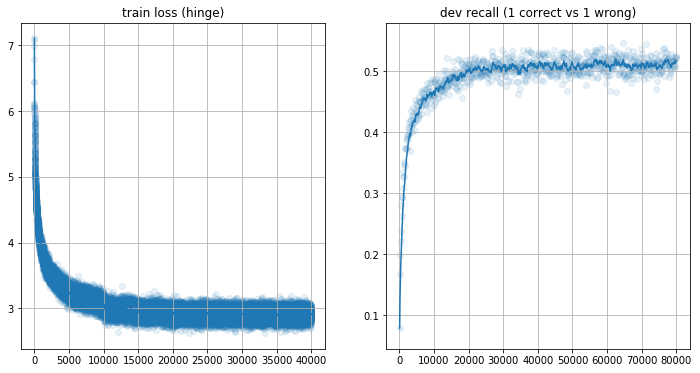




20000it [32:20,  5.01it/s]




In [271]:
# infinite training loop. Stop it manually or implement early stopping

for batch in tqdm(iterate_minibatches(train, batch_size=1500, total_batch_num=20000, cycle=True)):
    feed = {placeholders["names"] : batch["names"], placeholders['target']: batch['correct']}
    loss_t, _ = sess.run([loss, step], feed)
    loss_history.append(loss_t)

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        dev_batch_pred = sess.run(pred_logits, {placeholders['names']: dev_batch['names']})
        acc = accuracy_score(dev_batch['correct'], np.argmax(dev_batch_pred, axis=1))
        dev_recall_history.append(acc)
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    

In [253]:
sess.run(global_step)

20000

In [272]:
test_data = pd.read_csv('names_and_rubrics_test_no_rubric.csv')
test_data.head()

,Id,Category
0,1,Arena Stem
1,2,Муниципальное дошкольное образовательное бюдже...
2,3,Апартаменты на переулке Пилотов 10
3,4,Обсерватория Вологодского университета
4,5,Фармальянс


In [273]:
test_data_categ = test_data.Category.values

In [274]:
test_data.Category = [process_string(s) for s in test_data_categ]

In [275]:
test_data.head()

,Id,Category
0,1,arena stem
1,2,муниципальное дошкольное образовательное бюдже...
2,3,апартаменты на переулке пилотов
3,4,обсерватория вологодского университета
4,5,фармальянс


In [276]:
ans = np.zeros(len(test_data))

In [277]:
indices = np.arange(len(test_data))
for batch_start in tqdm(range(0, len(indices), 1024)):
    batch_indices = indices[batch_start: batch_start + 1024]
    batch = test_data.iloc[batch_indices]
    questions = batch['Category'].values
    ids = batch['Id'].values
    test_logits = sess.run(pred_logits, {placeholders['names']: questions})
    prediction = np.argmax(test_logits, axis=1)
    assert len(prediction) == len(questions)
    ans[batch_indices] = prediction




  0%|          | 0/977 [00:00<?, ?it/s]


  0%|          | 3/977 [00:00<00:48, 20.06it/s]


  1%|          | 5/977 [00:00<00:48, 19.91it/s]


  1%|          | 8/977 [00:00<00:48, 20.18it/s]


  1%|          | 10/977 [00:00<00:50, 19.29it/s]


  1%|          | 12/977 [00:00<00:52, 18.22it/s]


  1%|▏         | 14/977 [00:00<00:51, 18.57it/s]


  2%|▏         | 16/977 [00:00<00:51, 18.61it/s]


  2%|▏         | 18/977 [00:00<00:51, 18.72it/s]


  2%|▏         | 20/977 [00:01<00:50, 19.01it/s]


  2%|▏         | 22/977 [00:01<00:49, 19.12it/s]


  2%|▏         | 24/977 [00:01<00:49, 19.33it/s]


  3%|▎         | 26/977 [00:01<00:50, 18.76it/s]


  3%|▎         | 28/977 [00:01<00:50, 18.68it/s]


  3%|▎         | 30/977 [00:01<00:50, 18.58it/s]


  3%|▎         | 32/977 [00:01<00:51, 18.40it/s]


  3%|▎         | 34/977 [00:01<00:52, 17.86it/s]


  4%|▎         | 36/977 [00:01<00:52, 18.02it/s]


  4%|▍         | 38/977 [00:02<00:52, 17.77it/s]


  4%|▍         | 40/977 [00:02<00:51, 18

 29%|██▊       | 280/977 [00:15<00:38, 18.17it/s]


 29%|██▉       | 282/977 [00:15<00:37, 18.31it/s]


 29%|██▉       | 284/977 [00:15<00:37, 18.55it/s]


 29%|██▉       | 286/977 [00:15<00:37, 18.60it/s]


 29%|██▉       | 288/977 [00:15<00:37, 18.44it/s]


 30%|██▉       | 290/977 [00:16<00:36, 18.64it/s]


 30%|██▉       | 292/977 [00:16<00:38, 17.75it/s]


 30%|███       | 294/977 [00:16<00:38, 17.63it/s]


 30%|███       | 296/977 [00:16<00:37, 18.09it/s]


 31%|███       | 298/977 [00:16<00:38, 17.80it/s]


 31%|███       | 300/977 [00:16<00:38, 17.70it/s]


 31%|███       | 302/977 [00:16<00:36, 18.32it/s]


 31%|███       | 304/977 [00:16<00:36, 18.21it/s]


 31%|███▏      | 306/977 [00:16<00:37, 17.98it/s]


 32%|███▏      | 308/977 [00:17<00:37, 17.62it/s]


 32%|███▏      | 310/977 [00:17<00:37, 17.75it/s]


 32%|███▏      | 312/977 [00:17<00:37, 17.68it/s]


 32%|███▏      | 314/977 [00:17<00:38, 17.31it/s]


 32%|███▏      | 316/977 [00:17<00:37, 17.49it/s]


 33%|███▎   

 57%|█████▋    | 559/977 [00:30<00:23, 17.86it/s]


 57%|█████▋    | 561/977 [00:31<00:23, 17.67it/s]


 58%|█████▊    | 563/977 [00:31<00:23, 17.72it/s]


 58%|█████▊    | 565/977 [00:31<00:23, 17.70it/s]


 58%|█████▊    | 567/977 [00:31<00:23, 17.36it/s]


 58%|█████▊    | 569/977 [00:31<00:23, 17.61it/s]


 59%|█████▊    | 572/977 [00:31<00:22, 18.13it/s]


 59%|█████▉    | 574/977 [00:31<00:22, 17.61it/s]


 59%|█████▉    | 576/977 [00:31<00:22, 17.68it/s]


 59%|█████▉    | 578/977 [00:32<00:21, 18.18it/s]


 59%|█████▉    | 580/977 [00:32<00:22, 17.79it/s]


 60%|█████▉    | 583/977 [00:32<00:20, 18.77it/s]


 60%|█████▉    | 585/977 [00:32<00:21, 18.61it/s]


 60%|██████    | 587/977 [00:32<00:21, 18.43it/s]


 60%|██████    | 589/977 [00:32<00:20, 18.53it/s]


 60%|██████    | 591/977 [00:32<00:21, 17.67it/s]


 61%|██████    | 593/977 [00:32<00:21, 17.60it/s]


 61%|██████    | 595/977 [00:32<00:21, 17.97it/s]


 61%|██████    | 597/977 [00:33<00:21, 17.77it/s]


 61%|██████▏

 86%|████████▌ | 837/977 [00:46<00:07, 17.86it/s]


 86%|████████▌ | 839/977 [00:46<00:07, 18.34it/s]


 86%|████████▌ | 841/977 [00:46<00:07, 18.46it/s]


 86%|████████▋ | 843/977 [00:46<00:07, 18.20it/s]


 86%|████████▋ | 845/977 [00:46<00:07, 17.43it/s]


 87%|████████▋ | 847/977 [00:46<00:07, 17.32it/s]


 87%|████████▋ | 849/977 [00:46<00:07, 17.35it/s]


 87%|████████▋ | 851/977 [00:47<00:07, 17.35it/s]


 87%|████████▋ | 853/977 [00:47<00:07, 17.57it/s]


 88%|████████▊ | 855/977 [00:47<00:07, 17.14it/s]


 88%|████████▊ | 857/977 [00:47<00:06, 17.61it/s]


 88%|████████▊ | 859/977 [00:47<00:06, 17.75it/s]


 88%|████████▊ | 862/977 [00:47<00:06, 18.33it/s]


 88%|████████▊ | 864/977 [00:47<00:06, 17.47it/s]


 89%|████████▊ | 867/977 [00:47<00:06, 17.97it/s]


 89%|████████▉ | 869/977 [00:48<00:05, 18.11it/s]


 89%|████████▉ | 871/977 [00:48<00:05, 18.01it/s]


 89%|████████▉ | 873/977 [00:48<00:05, 17.83it/s]


 90%|████████▉ | 875/977 [00:48<00:05, 17.51it/s]


 90%|███████

In [278]:
ans[:10]

array([823., 246.,  69., 257.,  71., 980., 777., 501.,  45., 675.])

In [279]:
ans[-10:]

array([  10.,  675., 1147.,  494.,   69.,  501.,   94.,  246.,  675.,
         71.])

In [280]:
text_ans = l_enc.inverse_transform(np.array(ans, dtype=int))

In [281]:
text_ans[:5]

array(['Рекламное агентство', 'Детский сад', 'Апартаменты',
       'Дом культуры', 'Аптека'], dtype=object)

In [282]:
text_ans[-5:]

array(['Магазин продуктов', 'Банк', 'Детский сад',
       'Остановка общественного транспорта', 'Аптека'], dtype=object)

In [283]:
test_data.tail()

,Id,Category
999995,999996,стройкамень
999996,999997,почта банк
999997,999998,мбдоу детский сад
999998,999999,хартия м
999999,1000000,гуп то фармация


In [284]:
sub = pd.read_csv('sample.csv')

In [285]:
sub.head()

,Id,Category
0,1,Магазин одежды
1,2,Детский сад
2,3,Магазин одежды
3,4,Магазин одежды
4,5,Магазин одежды


In [286]:
sub.Category = text_ans

In [287]:
sub.head()

,Id,Category
0,1,Рекламное агентство
1,2,Детский сад
2,3,Апартаменты
3,4,Дом культуры
4,5,Аптека


In [288]:
sub.to_csv('deep_wide_40k_lower.csv', index=False)